# Transformer recipe generator analysis

Note: This notebook is designed to run with CPU (no GPU) runtime.

Install Huggingface libraries to use the pretrained tokenizer.

**You can igore the error message like `ERROR: pip's dependency resolver does not currently take into account...`.**

In [1]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install Google Translate library to convert generated texts to other languages.

In [2]:
pip install -q googletrans==4.0.0-rc1

Import modules and set random seeds.

In [3]:
import os, random
import numpy as np
from pandas import DataFrame
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, saving
from googletrans import Translator

random.seed(20230629)
np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [4]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print(f'Vocabulary size: {VOCAB_SIZE}')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Vocabulary size: 30522


Dfiner the Transformer encoder block.

In [5]:
@saving.register_keras_serializable()
class Embeddings(layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim, **kwargs):
        super(Embeddings, self).__init__(**kwargs)
        self.max_len = max_len
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim=vocab_size,
                                          output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=max_len,
                                        output_dim=embed_dim)
        self.dropout = layers.Dropout(rate=0.5)
        self.ln = layers.LayerNormalization(epsilon=1e-12)

    def build(self, input_shape):
        pass

    def call(self, inputs):
        seq_len = tf.shape(inputs)[-1]
        position_ids = tf.range(start=0, limit=seq_len, delta=1)
        position_embeddings = self.pos_emb(position_ids)
        token_embeddings = self.token_emb(inputs)

        # Add positional embeddings
        embeddings = token_embeddings + position_embeddings
        embeddings = self.ln(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "max_len": self.max_len,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

Define the Transformer model consisted of a single Transformer encoder blocks.

In [6]:
@saving.register_keras_serializable()
class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, key_dim, embed_dim, ff_dim, **kwargs):
        super(TransformerBlock, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.key_dim = key_dim
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.attn = layers.MultiHeadAttention(
            num_heads, key_dim, output_shape=embed_dim
        )
        self.dropout_1 = layers.Dropout(rate=0.1)
        self.ln_1 = layers.LayerNormalization(epsilon=1e-6)
        self.ffn_1 = layers.Dense(self.ff_dim, activation='relu')
        self.ffn_2 = layers.Dense(self.embed_dim)
        self.dropout_2 = layers.Dropout(rate=0.1)
        self.ln_2 = layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        pass

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        seq_len = tf.shape(inputs)[1]
        causal_mask = self.causal_attention_mask(
            batch_size, seq_len, seq_len, tf.bool)

        # Multi-head attention
        attention_output, attention_scores = self.attn(
            inputs,
            inputs,
            attention_mask=causal_mask,
            return_attention_scores=True,
        )
        attention_output = self.dropout_1(attention_output)
        attention_output =  attention_output + inputs # Skip connection
        attention_output = self.ln_1(attention_output)

        # Feed forward
        ffn_1 = self.ffn_1(attention_output)
        ffn_2 = self.ffn_2(ffn_1)
        ffn_output = self.dropout_2(ffn_2)
        ffn_output = ffn_output + attention_output # Skip connection
        ffn_output = self.ln_2(ffn_output)
        return (ffn_output, attention_scores)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "key_dim": self.key_dim,
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "ff_dim": self.ff_dim,
            }
        )
        return config

Mount the google drive and load the trained model.

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

#model_file = '/content/gdrive/My Drive/Transformer_recipe_generator.keras'
#transformer_model = saving.load_model(model_file)
#transformer_model.summary()

model_file = '/content/gdrive/My Drive/Transformer_attention_scores.keras'
attention_scores_model = saving.load_model(model_file)
attention_scores_model.summary()

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model: "Transformer_attention_scores"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ text_embedding (Embeddings)          │ (None, None, 512)           │      15,693,824 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Transformer (TransformerBlock)       │ [(None, None, 512), (None,  │       3,152,384 │
│                                      │ 4, None, None)]             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax (Dense)                      │ (None, None, 30522)         │      15,657,786 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 34,503,994 (131.62 MB)

 Trainable params: 34,503,994 (131.62 MB)

 Non-trainable params: 0 (0.00 B)

Define a function to generate new texts.

In [8]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    answer = prompt
    print(answer, end='')

    c = 1
    for i in range(512):
        probs, _ = attention_scores_model.predict(np.array([input_ids]), verbose=0)
        next_token, _ = sample_from(probs[0][-1], temp)
        input_ids = np.append(input_ids, next_token)

        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        if next_word.startswith('##'):
            next_word = next_word[2:]
        elif next_word not in ['.', ',', ':', ';', '?', '!']:
            next_word = ' ' + next_word
        print(next_word, end='')
        answer += next_word
        if len(answer) > c * 100:
            c += 1
            print('')
    print('')

    if lang == 'en':
        return answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return translated.text

Generate some sample texts.

In [9]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

Recipe for beef taco pizza: heat a skillet over medium - high heat, and cook and stir beef in olives,
 and stir until the beef is crumbly, 5 to 7 minutes; drain excess grease and discard grease. mix in green
 bell pepper, salsa, and chopped onion in skillet over medium - high heat; saute ground beef and
 ginger with the beef; cook and stir until beef is crumbly, 10 to 12 minutes. drain. stir ketchup, and
 brown sugar into beef mixture to skillet. cook and stir beef until beef is browned, about 5 minutes
. reduce


'ビーフタコピザのレシピ：ミディアムの強火でフライパンを加熱し、オリーブで牛肉を調理してかき混ぜ、牛肉が5〜7分で砕くまでかき混ぜます。余分なグリースを排出し、グリースを捨てます。緑色のピーマン、サルサ、刻んだタマネギをミディアム - 高熱の上で混ぜます。牛肉と生ingerを牛肉と炒めます。牛肉が砕けやすくなるまで、10〜12分になるまで調理してかき混ぜます。ドレイン。ケチャップをかき混ぜ、ブラウンシュガーはフライパンに牛肉の混合物に混ぜます。牛肉が茶色になるまで約5分間牛肉を調理してかき混ぜます。減らす'

In [10]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

Recipe for beef stew: place beef in a large pot over medium - high heat, and cook until evenly brown.
 drain fat, and stir in diced tomatoes with juice and season with salt and pepper. bring to a boil, reduce
 heat to low, cover, and simmer for 20 minutes. stir in the green onions, and tomato paste. cook
 and stir for 5 minutes. stir in the chicken broth, worcestershire sauce, and salt into the beef mixture
. bring to a boil, then reduce heat to low, cover, and simmer until the beef is tender, about 20
 minutes. remove the beef from the beef


'ビーフシチューのレシピ：牛肉を中程度の強火で大きな鍋に入れ、均等に茶色になるまで調理します。脂肪を排出し、さいの目に切ったトマトをジュースと一緒にかき混ぜ、塩とコショウで味付けします。沸騰させ、熱を低くし、覆い、20分間煮ます。緑の玉ねぎとトマトペーストをかき混ぜます。5分間調理してかき混ぜます。チキンスープ、ウスターソース、塩の混合物に塩を入れます。沸騰させてから、熱を低くし、覆い、牛肉が柔らかくなるまで約20分間煮ます。牛肉を牛肉から取り除きます'

In [11]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

Recipe for beef kushiyaki: bring a large pot of lightly salted water to a boil. add pasta and cook for
 8 to 10 minutes or until al dente; drain. heat the olive oil in a skillet over medium heat. add the
 onion and cook until translucent, about 5 minutes. add the onion and cook for 2 minutes. stir in the
 garlic, and cook until the onion has softened and turned translucent, about 5 minutes. stir in the
 garlic, and cook until the liquid has reduced by half. pour in the white wine, and season with salt
 and pepper. bring to a boil, then reduce


'クシヤキのレシピ：軽く塩水の大きな鍋を沸騰させます。パスタを加えて、8〜10分間またはアルデンテまで調理します。ドレイン。オリーブオイルを中火でフライパンで加熱します。タマネギを加え、半透明になるまで約5分間調理します。タマネギを加え、2分間調理します。ニンニクをかき混ぜ、タマネギが柔らかくなり、半透明になるまで約5分間調理します。ニンニクをかき混ぜ、液体が半分減少するまで調理します。白ワインを注ぎ、塩とコショウで味付けします。沸騰させてから減らします'

In [12]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

Recipe for apple spaghetti muffins: preheat oven to 350 degrees f ( 175 degrees c ). spray 36 muffin cups
 with cooking spray. whisk together butter, white sugar, white sugar, butter, corn meal, and vanilla
 together in a bowl. cook and stir until thick and creamy. mix in flour, cinnamon, cinnamon, and
 ginger together in a bowl. fold in mashed bananas with flour mixture. spoon batter on prepared muffin
 cups, filling each muffin cup 2 / 3 / 3 full. bake in the preheated oven, until a toothpick inserted
 into center of mu


'Apple Spaghetti Muffinsのレシピ：オーブンを350度F（175度C）に予熱します。調理スプレーで36個のマフィンカップをスプレーします。バター、白砂糖、白砂糖、バター、コーンミール、バニラをボウルに一緒に泡立てます。厚くてクリーミーになるまで調理してかき混ぜます。小麦粉、シナモン、シナモン、生ingerをボウルに混ぜます。小麦粉の混合物でマッシュバナナを折ります。準備したマフィンカップにスプーンバッター、各マフィンカップ2/3/3を満たします。予熱されたオーブンで焼き、ええの中央につまようじが挿入されるまで'

In [13]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

Recipe for apple bread: preheat oven to 375 degrees f ( 190 degrees c ). grease and flour a 9x5 - inch
 loaf pan. in a large bowl, beat the eggs, sugar, and vanilla extract together in a bowl using an electric
 mixer until light and fluffy. beat in egg yolks one at a time, mixing well after each addition
. add in the flour mixture and stir until just incorporated. fold in chocolate chips and pecans. spoon
 batter into prepared pan. bake in the preheated oven until a toothpick inserted into the center
 of the center of the loaf comes out clean


'リンゴパンのレシピ：オーブンを375度F（190度C）に予熱します。グリースと小麦粉A 9x5 -インチローフパン。大きなボウルで、卵、砂糖、バニラの抽出物をボウルに抽出し、電動ミキサーを使用して軽くふわふわします。卵黄を一度に1つずつ叩き、追加するたびによく混合します。小麦粉の混合物を加え、ただ取り入れるまでかき混ぜます。チョコレートチップとピーカンを折ります。調製した鍋にスプーンバッター。パンの中央の中央に挿入されたつまようじがきれいになるまで、予熱したオーブンで焼きます'

In [14]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

Recipe for apple bread pudding: preheat oven to 350 degrees f ( 175 degrees c ). grease and flour a 9
x5 - inch loaf pan. combine the flour, sugar, baking powder, and salt in a bowl. beat in eggs one at
 a time, then stir in milk, and vanilla extract. pour batter into prepared pan. bake in the preheated
 oven for 60 minutes, or until a toothpick inserted into center of the center of the cake comes out
 clean. allow to cool completely before removing from the pan.


'リンゴパンプディングのレシピ：オーブンを350度F（175度C）に予熱します。グリースと小麦粉A 9x5 -インチローフパン。小麦粉、砂糖、ベーキングパウダー、塩をボウルに混ぜます。卵を一度に1つずつ叩き、牛乳をかき混ぜ、バニラ抽出物を入れます。準備されたパンにバッターを注ぎます。予熱したオーブンで60分間、またはケーキの中央の中央に挿入されたつまようじがきれいになるまで焼きます。パンから外す前に完全に冷まします。'

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [50]:
prompts = [
    'recipe for chicken breasts : mix the garlic powder with',
    'recipe for beef steak: bring a large pot of'
]

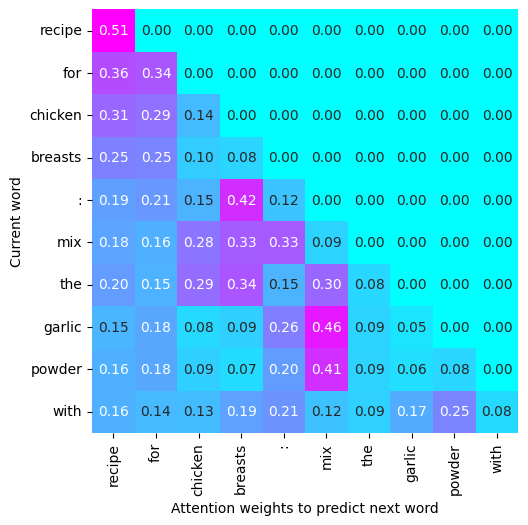

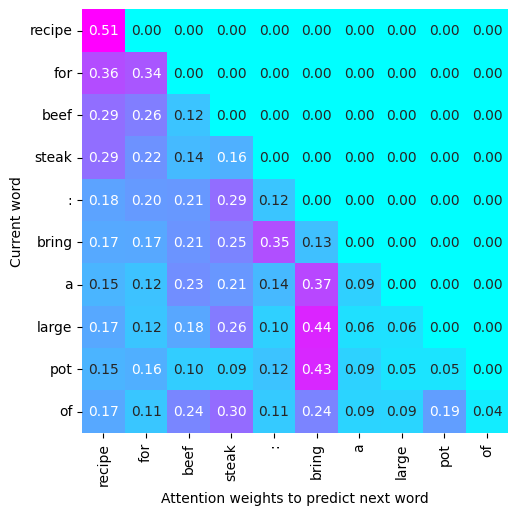

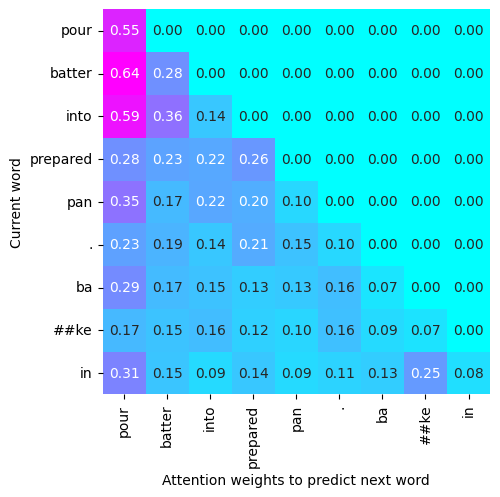

In [49]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(
                                np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(
        np.max(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
        ax = subplot,
        cmap='cool', cbar=False, annot=True, fmt='1.2f')
    heatmap.set_xticklabels(labels[1:text_len], rotation = 90)
    heatmap.set_yticklabels(labels[1:text_len], rotation = 0)
    _ = heatmap.set(xlabel='Attention weights to predict next word',
                    ylabel='Current word')